## Preference-Based Recommendation System for Groups

Algorithmic Marketing Class Project

Name: Li Liu, Suresh Govindaraj, Xi Zhao

Date: March 2020

A group of people wanted to have an amazing restaurant dining experience in Las Vegas. Some of them were attracted by a French restaurant 30 min away. Some of them thought the nearby sushi place was good enough. They opened Yelp and set the filters. But it didn't help them decide because the app showed each of them very different results.

Here comes our system. We want to help them decide which ones work best for them all.

Using our utility maximization framework, our system recommends the restaurants that will most likely maximize their total utilities.

Suppose we have three people: A, B, C are choosing from N restaurants (R indicates restaurants factors).

For each restaurant i (i=1...N), each person would have a utility for i: $u_A(R_i)$, $u_B(R_i)$, $u_C(R_i)$

We need to have a match function for predicting the total utilities from eating at this restaurant, such that $m_{R_i}(A,B,C) = U_{i}(u(R_i), R_i, Weights, Preferences)$

Our core algorithm will account for the following factors:

* Each restaurant has a baseline utility for the group (Think of $\beta_0$). We use machine learning to predict this utility by using the existing _**Yelp reviews data**_.

Then we will use _**users' input data**_ to adjust the baseline utility based on the groups' preferences and consensus ($\sum_k(\prod_m(p_m*w_m)X_k)$): 

* People have different voting weights (Ex. parents make the final decision instead of kids)

* People have own preferences (Ex. not important at all, neutral, very important)

* People care about others. The total utility depends on others' preference. If A knows B and C hate pizza, the utility for A to choose a pizza place will be lower than the case if A dining alone. 

When A, B, C open the system, they will be asked to choose their preferences for distance and cuisine types. If the factor is not important for A at all, the $p_{A}=0.1$. If the factor is neutral for A, the $p_{A}=0.5$. If the factor is very important for A, the $p_{A}=1$. Also, they have different voting weights w, $w_A, w_b, w_C$, and $w_A+w_b+w_C=1$, 

Generally, suppose we have M (m=1...M) people to choose from N (i=1...N) restaurants and the system asks them to answer K (k=1...K) questions:

$$U_{i} = \beta_0 + \beta_1X_1+ \beta_2X_2+...+\beta_kX_k+\epsilon$$
$$\hat{U_{i}}= \hat{f}(Restaurant Reputations, Weekend, Group...) + \sum_k(\prod_m(p_m*w_m)X_k)$$

Then we have scores for all restaurants from i=1 to N. We can sort them and recommend the top ones for the group.

#### Import packages

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
sns.set_style("white")
plt.style.use('seaborn-deep')

start=time.time()

#### Read in data

In [1]:
# review 
rev = pd.read_csv("yelp_review.csv")
print("total review text", rev.shape)
rev.head(2)

<IPython.core.display.Javascript object>

total review text (5261668, 9)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0


#### Subset the data 

1. Only restaurants in Las Vegas

2. Join data from business and users

In [2]:
# business
bus = pd.read_csv("yelp_business.csv")
print("total business",bus.shape)

# select restaurants in LV
LV = bus[bus["city"] == "Las Vegas"]
LVR = LV[LV['categories'].str.contains('Restaurants') == True] 

# select only open restaurants; drop uninformative features
LVR = LVR[LVR["is_open"]==1]
LVR = LVR.drop(["city", "state", "postal_code"], axis=1)

print("total open restaurants", LVR.shape)

<IPython.core.display.Javascript object>

total business (174567, 13)
total open restaurants (3990, 10)


In [3]:
# user data
user = pd.read_csv("yelp_user.csv")
user.shape

<IPython.core.display.Javascript object>

(1326100, 22)

In [4]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful',
       'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

##### Aggregate data 
Each line represents a review for a restaurant by one user

In [5]:
agg = pd.merge(LVR, rev, how="left", on="business_id")
agg = pd.merge(agg, user, how="left", on="user_id")
agg.rename(columns = {'stars_x':"star_bus", "review_count_x": "cts_bus",
                      "stars_y": "star_customer"},
           inplace = True)
agg.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(795588, 39)

##### Only keep the most relevant reviews

Restaurants normally update and improve products and services constantly to satisfy customers' needs, especially at Las Vegas. We will only keep the reviews in the last year.

In [6]:
agg["DATE"] = pd.to_datetime(agg["date"], format = '%Y/%m/%d')
agg["date_yr"] = agg["DATE"].dt.year
agg["date_mt"] = agg["DATE"].dt.month

<IPython.core.display.Javascript object>

In [7]:
agg["DATE"].describe()

count                  795588
unique                   4317
top       2017-08-12 00:00:00
freq                      766
first     2005-01-26 00:00:00
last      2017-12-11 00:00:00
Name: DATE, dtype: object

In [12]:
agg = agg[agg["date_yr"]>=2017]
agg.shape

(181144, 42)

In [13]:
# skim data
agg.head(5)

,business_id,name_x,neighborhood,address,latitude,longitude,star_bus,cts_bus,is_open,categories,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,DATE,date_yr,date_mt
0,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,...,0,0,2,1,1,0,0,2017-03-27,2017,3
14,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,1,Fast Food;Restaurants;Sandwiches,...,0,22,144,82,82,18,53,2017-09-27,2017,9
17,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,1,Fast Food;Restaurants;Sandwiches,...,0,1,3,2,2,2,3,2017-09-14,2017,9
18,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,1,Fast Food;Restaurants;Sandwiches,...,0,0,0,0,0,0,0,2017-09-28,2017,9
23,n7V4cD-KqqE3OXk0irJTyA,"""GameWorks""",Southeast,"""6587 Las Vegas Blvd S, Ste 171""",36.068259,-115.178877,3.0,349,1,Arcades;Arts & Entertainment;Gastropubs;Restau...,...,0,0,0,0,0,0,0,2017-03-03,2017,3


In [10]:
# current columns
agg.columns

Index(['business_id', 'name_x', 'neighborhood', 'address', 'latitude',
       'longitude', 'star_bus', 'cts_bus', 'is_open', 'categories',
       'review_id', 'user_id', 'star_customer', 'date', 'text', 'useful_x',
       'funny_x', 'cool_x', 'name_y', 'review_count_y', 'yelping_since',
       'friends', 'useful_y', 'funny_y', 'cool_y', 'fans', 'elite',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos', 'DATE',
       'date_yr', 'date_mt'],
      dtype='object')

In [62]:
#Subset the data to speed up execution
#sample = 10000
#agg = agg.iloc[:sample]

### Baseline utility: predicted rescaled satisfaction scores

y is the measure for customer satisfaction. We reweighed and rescaled the star ratings.

In [16]:
# individual ratings for particular restaurants are positive correlated with their average ratings for all reviews
np.corrcoef(agg['average_stars'],  agg["star_customer"])[0,1]

<IPython.core.display.Javascript object>

0.5476607687570102

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Hexbin plot of Customer Current and Previous Ratings')

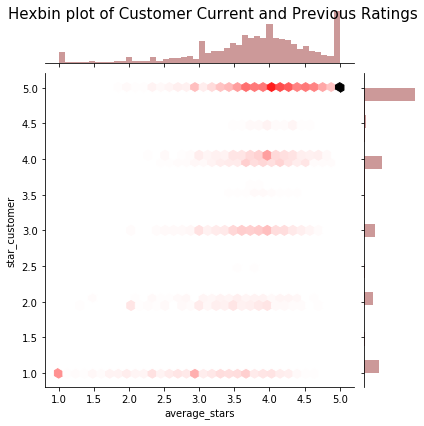

In [18]:
# Hexbin plot
agguser = agg[:10000].groupby('user_id')[['star_customer', 'average_stars']].mean()

sns.jointplot(agguser['average_stars'], agguser["star_customer"], 
              kind='hex', color='maroon')

plt.suptitle("Hexbin plot of Customer Current and Previous Ratings", fontsize=15)
#plt.savefig('HexbinPlot of Customer Current and Previous Ratings .png')

In [19]:
agg[['average_stars',"star_customer"]].head(5)

,average_stars,star_customer
0,3.00,4
14,4.58,4
17,3.74,5
18,1.89,1
23,3.83,5


##### Potential issue

Customers have different rating standards. So a rating of 3 could mean different satisfaction by two customoers, if one has average ratings of 5 (implying dissatisfaction) and the other has average rating of 1 (implying satisfaction). I solve this by reweighting the individual ratings by their average ratings.

In [20]:
# reweighed and rescaled consumer satisfaction measure

# a. Account for the "extra" part deviated from the average ratings
agg['y2'] = agg['star_customer'] + (agg['star_customer']-agg['average_stars'])/agg['average_stars']

# b. Normalization
agg['normy'] = (agg['y2'] - np.mean(agg['y2']))/np.std(agg['y2'])

# c. Rescale to 0-100 
agg['y'] = ((100 - 0) / (max(agg['normy'] ) - min(agg['normy'] ))) * (agg['normy'] - min(agg['normy'])) + 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Test cases

In [21]:
# case when relative rating is high
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==100]

,average_stars,star_customer,y2,normy,y
116773,1.36,5,7.676471,2.209572,100.0


In [22]:
# case when relative rating is low
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==0]

,average_stars,star_customer,y2,normy,y
588474,4.9,1,0.204082,-2.11435,0.0


##### Summary statistics

In [23]:
# statistics of original scores and transformed scores
agg[['star_customer','y']].describe()

,star_customer,y
count,181144.000000,181144.000000
mean,3.847006,48.898888
std,1.427706,23.127218
min,1.000000,0.000000
25%,3.000000,34.516514
50%,4.000000,55.686422
75%,5.000000,66.730929
max,5.000000,100.000000


In [25]:
# abbreviation

# Y is the categorical star rating
Y = agg["star_customer"]
# y is the reweighted numerical grade with 0-100 scale
y = agg['y']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Histogram of the Consumer Satisfaction Score')

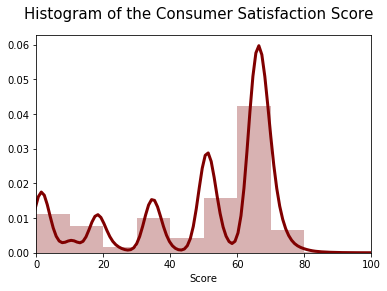

In [26]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':3})

sns.distplot(y, bins=10, color="maroon", label="score", **kwargs)
plt.xlim(0,100)
plt.xlabel("Score")
plt.suptitle("Histogram of the Consumer Satisfaction Score", fontsize=15)
#plt.savefig("Histogram of the Consumer Satisfaction Score.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Pie Chart of Stars Ratios')

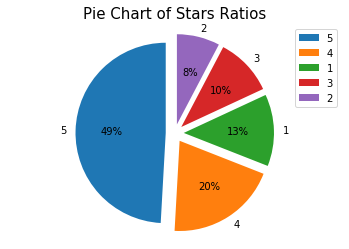

In [27]:
labels = Y.value_counts().index
fig1, ax1 = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
ax1.pie(Y.value_counts(),  explode = explode, labels = Y.value_counts().index,
         autopct='%1.0f%%', startangle = 90)
ax1.axis('equal') 
plt.legend()
plt.title("Pie Chart of Stars Ratios", fontsize = 15)
#plt.savefig("Pie Chart of Stars Ratios")

### Independent variables (users' inputs)

##### Restaurants Current Total Stars and Review Counts 

This serves as prior info for consumers

Customers think the restaurants' reputations are highly predictive of their dining experience.

In [28]:
X = agg[['cts_bus', 'star_bus', 'y2']]

In [30]:
# create quarter index
def quarter(df):
    
    ind = (df["date_yr"]-2017)*4
    
    if df["date_mt"]>=1 and df["date_mt"]<=3:
        return ind+0
    elif df["date_mt"]>=4 and df["date_mt"]<=6:
        return ind+1
    elif df["date_mt"]>=7 and df["date_mt"]<=9:
        return ind+2
    else:
        return ind+3
    
agg["quarter"] = agg.apply(quarter, axis=1)
aggdate = agg.groupby(["quarter"])[["y2", "star_bus"]].mean()
aggdate

,y2,star_bus
quarter,,
0,3.876744,3.852100
1,3.839799,3.848572
2,3.847568,3.860315
3,3.874425,3.877037


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

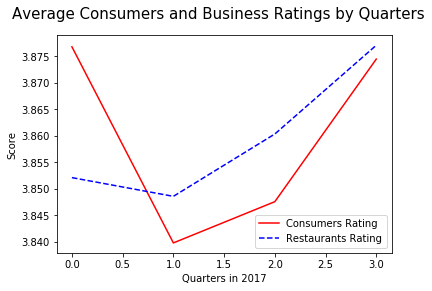

In [33]:
plt.plot(aggdate.index, aggdate["y2"], '-r', label='Consumers Rating')
plt.plot(aggdate.index, aggdate["star_bus"], '--b', label='Restaurants Rating')
plt.suptitle("Average Consumers and Business Ratings by Quarters", fontsize=15)
plt.legend()
plt.xlabel("Quarters in 2017")
plt.ylabel("Score")
plt.savefig("Average Consumers and Business Ratings by Quarters.png")

##### Detrending

Problem: average rating increases every year. One possible reason: restaurants give incentives to customers who give high ratings (then the ratings and reviews might be biased)

!! This part is particularly useful when I used all reviews when there is a 12 years gap. Since I now focus only on reviews in 2017, this part is optional and not significant.

Across different years, the means of the scores seem to be growing. Thus the scores is not stationary. We need to de-trend this variable for the analysis. This could be done by calculating the average growth rate in scores across all quarters and dividing each score by (1 + avg_growth_rate) ** (quarter-0).

This method is adopted from detrending the inflation effect in macroeconomics.

In [34]:
avg_score_by_quarter =  agg.groupby(["quarter"])[["y2"]].mean().values

# Calculate the average growth rate in salaries across all quarters
avg_growth_rate = ((avg_score_by_quarter[1:] - avg_score_by_quarter[:-1]) / avg_score_by_quarter[:-1]).mean()
#avg_growth_rate = 2.73

# Divide each salary by (1 + avg_growth_rate) ** (grad_year - baseline)
agg['rate'] = (1 + avg_growth_rate) ** (agg.quarter-0)
agg['y2_new'] = agg['y2']/agg['rate']
agg['star_bus_new'] = agg['star_bus']/agg['rate']

# Replace with new adjusted numbers
X['star_bus'] = agg['star_bus_new']
X['y2'] = agg['y2_new']

C:\Users\lliu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\lliu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

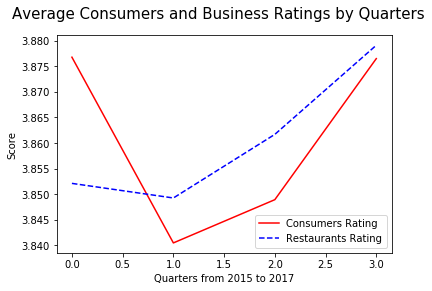

In [35]:
aggdate = agg.groupby(["quarter"])[["y2_new", "star_bus_new"]].mean()
plt.plot(aggdate.index, aggdate["y2_new"], '-r', label='Consumers Rating')
plt.plot(aggdate.index, aggdate["star_bus_new"], '--b', label='Restaurants Rating')
plt.suptitle("Average Consumers and Business Ratings by Quarters", fontsize=15)
plt.legend()
plt.xlabel("Quarters from 2015 to 2017")
plt.ylabel("Score")
plt.savefig("Average Consumers and Business Ratings by Quarters.png")

In [36]:
np.corrcoef(X["star_bus"], X["cts_bus"])[0,1]

<IPython.core.display.Javascript object>

0.08843825205720601

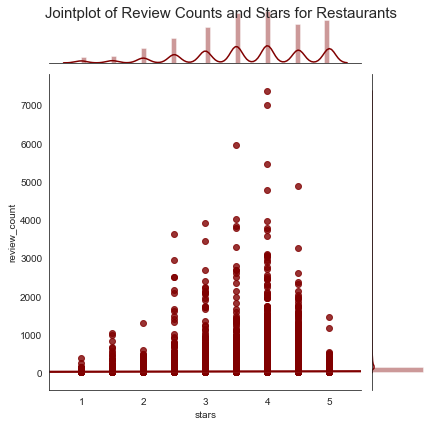

In [114]:
# hexagonal bins
sns.jointplot(bus['stars'], bus['review_count'],kind="reg", color="maroon")
plt.suptitle("Jointplot of Review Counts and Stars for Restaurants", fontsize=15)
plt.savefig("stars_review.png")

In [39]:
# Rescale y2 to 0-100 scale again
# b. Normalization
X['normy'] = (X['y2'] - np.mean(X['y2']))/np.std(X['y2'])

# c. Rescale to 0-100 
X['y'] = ((100 - 0) / (max(X['normy'] ) - min(X['normy'] ))) * (X['normy'] - min(X['normy'])) + 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\lliu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lliu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Gender

In [43]:
guess = gender.Detector()
agg["guess"] = [guess.get_gender(i) for i in agg["name_y"]]
X['gender'] = np.where(agg["guess"].str.contains("female"), 1, 0)
print("Ratio of females inferred from the names:",
      round(X['gender'].sum()/X.shape[0], 2))

Ratio of females inferred from the names: 0.45


Text(0.5, 0.98, 'Histogram of Satisfaction Scores by Gender')

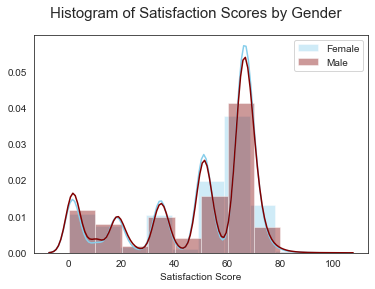

In [44]:
sns.distplot(X[X['gender']==1]['y'], bins=10,  color="skyblue", label="Female")
sns.distplot(X[X['gender']==0]['y'], bins=10, color="maroon", label="Male")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by Gender', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by Gender.png')

In [45]:
# dataframe for plot
XG = X.groupby('gender').mean().round(2)
XG.head()

,cts_bus,star_bus,y2,normy,y
gender,,,,,
0,771.53,3.85,3.82,-0.02,48.45
1,791.59,3.87,3.90,0.02,49.47


In [70]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(XG, header_columns=0, col_width=2.0)
#plt.savefig('gendertable.png')

##### Weekend 

In [46]:
# Monday 0 to Sunday 6
# Hypothesis: reviews written on Friday, Saturday, and Sunday are different from the ones written during weekdays
agg["dayofweek"] = agg["DATE"].dt.dayofweek
agg["dayofweek"].head()

0     0
14    2
17    3
18    3
23    4
Name: dayofweek, dtype: int64

In [47]:
def weekend(df):
    
    if df["dayofweek"]==4:
        return 1
    elif df["dayofweek"]==5:
        return 1
    elif df["dayofweek"]==6:
        return 1   
    else:
        return 0

In [48]:
X["weekend"] = agg.apply(weekend, axis=1)
X["weekend"].value_counts()

0    98722
1    82422
Name: weekend, dtype: int64

In [50]:
stats.describe(X[X["weekend"]==0]['y'])

DescribeResult(nobs=98722, minmax=(0.0, 100.0), mean=49.05889029897076, variance=525.2944618678182, skewness=-0.9402636163501465, kurtosis=-0.43563771670467055)

In [51]:
stats.describe(X[X["weekend"]==1]['y'])

DescribeResult(nobs=82422, minmax=(0.022007274868150524, 99.34065738775402), mean=48.73452147219568, variance=546.9177788331199, skewness=-0.9145230553491156, kurtosis=-0.5384020224468955)

Text(0.5, 0.98, 'Histogram of Satisfaction Scores by Weekend/Weekday')

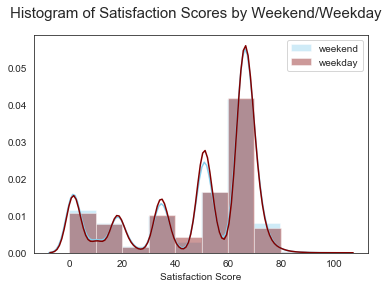

In [52]:
sns.distplot(X[X['weekend']==1]['y'], bins=10, color="skyblue", label="weekend")
sns.distplot(X[X['weekend']==0]['y'], bins=10, color="maroon", label="weekday")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by Weekend/Weekday', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by WeekendWeekday.png')

##### Vegan-friendly

https://www.allrecipes.com/recipes/265/everyday-cooking/vegetarian/main-dishes/

In [94]:
veg_keywords = ["vegan", "animal-free", "vegetarian",  
                "flexitarian", "pescetarian", "freegan", "veggie",
                "vegetables", "tofu", "chickpea", "eggplant", 
                "salad", "falafels", "bean", "spinach", 
                "zucchini", "spinach", "pepper", "lentil", 
                "mushroom", "onion"]

def vegan(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in veg_keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["vegan"] = agg.apply(vegan, axis=1)

In [95]:
X["vegan"].value_counts()

0    159734
1     21410
Name: vegan, dtype: int64

##### Kids-friendly

In [104]:
kid_keywords = ["child", "children", "kid", "kids", 
                "kid's", "kid-friendly", "baby"]

def kid(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in kid_keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["kid"] = agg.apply(kid, axis=1)

In [105]:
X["kid"].value_counts()

0    176338
1      4806
Name: kid, dtype: int64

##### With group

In [53]:
keywords = ["we", "our", "us", "daughter", "son", "children", "kids", "family",
           "friends", "friend", "guests", "buddy", "colleagues", "wife", "husband",
            "partner", "birthday", "group", "party"]

def withgroup(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["group"] = agg.apply(withgroup, axis=1)

In [54]:
X["group"].value_counts()

1    91905
0    89239
Name: group, dtype: int64

In [55]:
stats.describe(X[X["group"]==0]['y'])

DescribeResult(nobs=89239, minmax=(0.0, 99.34065738775402), mean=49.68830348720767, variance=525.9589375468757, skewness=-0.9865176389781612, kurtosis=-0.35176737136964853)

In [56]:
stats.describe(X[X["group"]==1]['y'])

DescribeResult(nobs=91905, minmax=(0.022007274868150524, 100.0), mean=48.15683566706249, variance=542.9373786847711, skewness=-0.8748305040280878, kurtosis=-0.5972288646327879)

Text(0.5, 0.98, 'Histogram of Satisfaction Scores by (Not) With Groups')

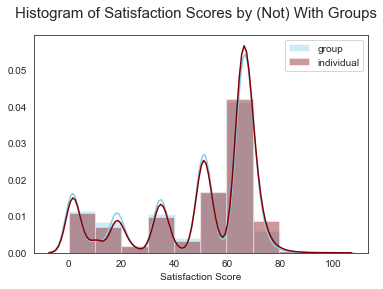

In [57]:
sns.distplot(X[X['group']==1]['y'], bins=10, color="skyblue", label="group")
sns.distplot(X[X['group']==0]['y'], bins=10, color="maroon", label="individual")
plt.legend()
plt.xlabel('Satisfaction Score')
plt.suptitle('Histogram of Satisfaction Scores by (Not) With Groups', fontsize=15)
#plt.savefig('Histogram of Satisfaction Scores by (Not) With Groups.png')

##### Food Categories

In [58]:
Ameri = ["American (New)", "American (Traditional)", "Burgers", "Chicken Wings",
        "Fast Food", "Hot Dogs", "Salad", "Sandwiches", "Barbeque"
         "Smokehouse", "Pizza", "Cheesesteaks", "Cafeteria"]
Europ = ["Italian", "French", "British", "Hungarian", "lombian","Portuguese", "German",
         "Russian", "Spanish", "Ukrainian", "Fish & Chips", 
         "Greek", "Irish", "Modern European", "Polish", "Bulgarian", "Armenian"]
SouAM = ["Mexican", "Argentine", "Cajun", "Caribbean", "Peruvian",
         "Honduran", "Salvadoran", "Venezuelan", "Puerto Rican", "Tex-Mex", 
         "New Mexican Cuisine", "Nicaraguan", "Tacos", "Latin American"]
Asian = ["Thai", "Japanese", "Fusion", "Korean",
          "Filipino","Hawaiian", "Curry", "Asian", "Pan Asian",
         "Soba", "Vietnamese", "Singaporean", "Mongolian", 
         "Guamanian", "Himalayan/Nepalese", "Malaysian",
         "Middle Eastern", "Sushi Bars", "Hong Kong Style Cafe", "Bubble Tea"]
Indian = ['Indian']
Chinese = ["Chinese",  "Taiwanese", "Cantonese", "Shanghainese", "Szechuan",
          "Dim Sum", "Ramen", "Hot Pot"]
MidEas = ["Mediterranean","Kebab", "Pakistani", "Persian/Iranian", "Falafel", "Lebanese"]
Drinks = ["Beer", "Coffee", "Wine Bars", "Pubs",  "Wineries", 
          "Wine & Spirits", "Tea Rooms", "Irish Pub", "Juice Bars & Smoothies", "Bars"]

def fooddummy(df, keywords):
    for key in keywords: 
        if key in df['categories']:
            return 1     
    return 0

# Full List (Too slow to run through)
FoodCate = ["Ameri", "Europ", "SouAM", "Asian", 
            "Indian", "Chinese", "MidEas", "Drinks"]
FoodCateKeys = [Ameri, Europ, SouAM, Asian, 
                Indian, Chinese, MidEas, Drinks]

#Simplified List (Just pick two most unique categories)
#FoodCate = ["Asian", "Drinks"]
#FoodCateKeys = [Asian, Drinks]

#c reate new column for food categories
for index, name in enumerate(FoodCate):
    X[name] = agg.apply(fooddummy, args=(FoodCateKeys[index],), axis=1)

In [59]:
def category(df):
    
    if df['Ameri'] == 1:
        return 'American'
    elif df['Europ'] == 1:
        return 'Europe'
    elif df['SouAM'] == 1:
        return 'South American'
    elif df['Asian'] == 1:
        return 'Asian'
    elif df['Indian'] == 1:
        return 'Indian'
    elif df['Chinese'] == 1:
        return 'Chinese'
    elif df['MidEas'] == 1:
        return 'Middle East'
    elif df['Drinks'] == 1:
        return 'Bars & Drinks'
    else:
        return 'Others'
    
X['category'] = X.apply(category, axis = 1)

In [60]:
X['category'].value_counts()

American          88382
Asian             34509
Europe            15237
South American    15033
Others            13998
Bars & Drinks      6608
Chinese            4902
Indian             1636
Middle East         839
Name: category, dtype: int64

###### Overlapping densities visualization

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

https://seaborn.pydata.org/examples/kde_ridgeplot.html    

Text(0.5, 8.959999999999994, 'score')

<Figure size 576x720 with 0 Axes>

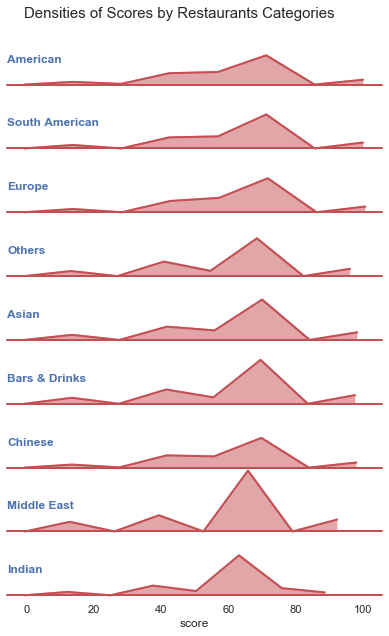

In [61]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize = (8,10))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(X, row="category", hue="category", aspect=6, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "y", clip_on=False, shade=True, color="r", gridsize=8, alpha=0.5, lw=2, bw=.2)
g.map(sns.kdeplot, "y", clip_on=False, color="r", gridsize=8,  lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, color="r", clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .4, label, fontweight="bold", color="b",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "y")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Densities of Scores by Restaurants Categories', fontsize=15)
plt.xlabel('score')
#plt.savefig("DensitiesCategories.png")

In [48]:
#Coorelation Matrix Heatmap

#plt.matshow(X.corr())
#plt.xticks(range(len(X.columns)), X.columns)
#plt.yticks(range(len(X.columns)), X.columns)
#plt.colorbar()

### Machine Learning

The ML algorithm will predict our satisfaction (utility) from dining at a particular restaurant. The predicted score will be used to rank the filtered options.

#### Preview data

In [62]:
X = X.drop(["y", "category"], axis=1)
X.head()

,cts_bus,star_bus,y2,normy,gender,weekend,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks
0,13,4.000000,4.333333,0.274417,1,0,0,1,0,0,0,0,0,0,1
14,6,2.500878,3.874722,0.009107,0,0,1,1,0,0,0,0,0,0,0
17,6,2.500878,5.338772,0.856068,0,0,0,1,0,0,0,0,0,0,0
18,6,2.500878,0.529286,-1.926246,0,0,0,1,0,0,0,0,0,0,0
23,349,3.000000,5.305483,0.836811,0,1,0,1,0,0,0,0,0,0,0


In [63]:
y[:10]

0     55.260128
14    49.104521
17    68.690439
18     4.349598
23    68.270019
35    50.346709
40     1.997691
48    64.181862
53    44.107960
55     5.282390
Name: y, dtype: float64

In [111]:
# make sure the rows number match!
(X.shape,y.shape)

((181144, 15), (181144,))

#### Predictive Models

##### Feature importance using Random Forest

In [112]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 100,n_jobs = 4).fit(X, y)

for name,score in zip(X.columns, rfc.feature_importances_):
    print(name,score)

cts_bus 0.2907590221699483
star_bus 0.3944183387044239
gender 0.056872200771530046
weekend 0.07254058687820933
group 0.019226259316879223
Ameri 0.022267132812273514
Europ 0.011876855944651916
SouAM 0.01631572129207803
Asian 0.018349306662787047
Indian 0.0022685118517696886
Chinese 0.011556502265713427
MidEas 0.005624146475634684
Drinks 0.02262861240840721
vegan 0.04251403699888592
kid 0.012782765446807922


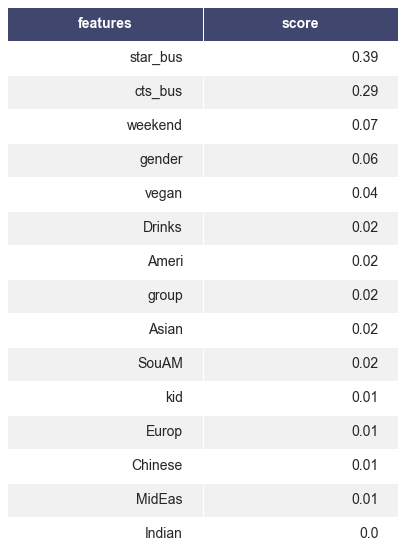

In [113]:
imp = pd.DataFrame({"features":X.columns, "score": rfc.feature_importances_})
imp = imp.sort_values(by='score', ascending=False)
imp = imp.round(2)
render_mpl_table(imp, header_columns=0, col_width=3.5)
plt.savefig('importance.png')

Text(0.5, 0, 'scores')

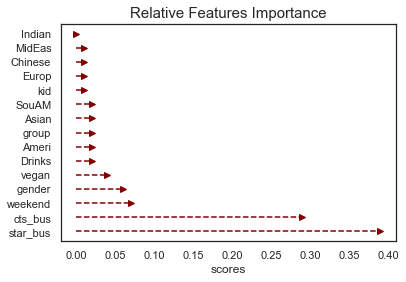

In [114]:
plt.hlines(y=imp["features"], xmin=0, xmax=imp['score'],
           linestyles ='dashed', color='maroon')

plt.plot(imp['score'], imp["features"], ">", color='maroon')
 
plt.yticks(imp["features"])
plt.title("Relative Features Importance", loc='center', fontsize=15)
plt.xlabel('scores')
#plt.savefig("Relative Features Importance.png")

Random Forest measures the relative importance of each predictor by counting the number of associated training samples in the 500 trees. 

In [115]:
#X=X.drop(["Ameri", "Europ", "SouAM", "Asian", "MidEas", "Drinks"], axis=1)
X.head()

,cts_bus,star_bus,gender,weekend,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks,vegan,kid
0,13,4.000000,1,0,0,1,0,0,0,0,0,0,1,0,0
14,6,2.500878,0,0,1,1,0,0,0,0,0,0,0,0,0
17,6,2.500878,0,0,0,1,0,0,0,0,0,0,0,0,0
18,6,2.500878,0,0,0,1,0,0,0,0,0,0,0,0,0
23,349,3.000000,0,1,0,1,0,0,0,0,0,0,0,0,0


##### Training and testing sets

In [116]:
# Divide the data into training and test set, with ratio 3:1 (test=25%).
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

 experiment with only most important features
X_train, X_test, y_train, y_test = train_test_split(X[["sentiment", "stars_x"]] , y, random_state=0)

##### Linear Regression

In [119]:
lin = LinearRegression().fit(X_train, y_train)

In [120]:
linkf = cross_val_score(lin, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-linkf.mean(),2))
print("Standard deviation:",round(linkf.std(),2))

Mean: 446.92
Standard deviation: 2.62


In [121]:
# What happends if we use the full data?
linfull = LinearRegression().fit(X, y)
linkffull = cross_val_score(linfull, X, y, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-linkffull.mean(),2))
print("Standard deviation:",round(linkffull.std(),2))

Mean: 447.48
Standard deviation: 11.81


In [122]:
lin.coef_

array([ 2.40279583e-01,  6.14069213e+01,  9.07844995e-01, -3.27212835e-01,
       -1.84112164e+00, -7.81952271e-01,  1.05445434e+00,  2.74485519e-02,
       -2.61304608e-03, -1.89289888e+00, -1.38613637e-01,  1.92170590e-02,
        3.58824124e-01,  4.19780411e-02, -2.33978439e+00])

In [123]:
lin.intercept_

5.887402334775217

In [125]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X2).fit()
#predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     1781.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:18:50   Log-Likelihood:            -6.0729e+05
No. Observations:              135858   AIC:                         1.215e+06
Df Residuals:                  135842   BIC:                         1.215e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8874      0.321     18.338      0.0

##### Lasso Regression


In [126]:
las = Lasso().fit(X_train, y_train)

In [134]:
alpha_grid = {"alpha":np.linspace(0,20,20)}
grid_search2 = GridSearchCV(las, param_grid=alpha_grid, n_jobs = 4, cv=5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)

print('GridBestEstimatorLasso=', grid_search2.best_estimator_)
print('GridBestParamsLasso=', grid_search2.best_params_)
print('GridBestScoreLasso=', -grid_search2.best_score_)

GridBestEstimatorLasso= Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
GridBestParamsLasso= {'alpha': 0.0}
GridBestScoreLasso= 446.92039299656125


In [128]:
las = Lasso(alpha=grid_search2.best_params_['alpha']).fit(X_train, y_train)
laskf = cross_val_score(las, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-laskf.mean(),2))
print("Standard deviation:",round(laskf.std(),2))

Mean: 446.92
Standard deviation: 2.62


In [133]:
las.coef_

array([ 2.40279583e-01,  6.14069213e+01,  9.07844995e-01, -3.27212835e-01,
       -1.84112164e+00, -7.81952271e-01,  1.05445434e+00,  2.74485519e-02,
       -2.61304608e-03, -1.89289888e+00, -1.38613637e-01,  1.92170590e-02,
        3.58824124e-01,  4.19780411e-02, -2.33978439e+00])

##### Ridge Regression

In [130]:
rid = Ridge(alpha=1).fit(X_train, y_train)

In [135]:
alpha_grid = {"alpha": np.linspace(1,20,20)}
grid_search1 = GridSearchCV(rid, param_grid = alpha_grid, n_jobs = 4, cv = 5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)
print('GridBestEstimatorRidge=', grid_search1.best_estimator_)
print('GridBestParamsRidge', grid_search1.best_params_)
print('GridBestScoreRidge=', -grid_search1.best_score_)

GridBestEstimatorRidge= Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
GridBestParamsRidge {'alpha': 1.0}
GridBestScoreRidge= 446.92037958902625


In [136]:
rid = Ridge(alpha=grid_search1.best_params_['alpha']).fit(X_train, y_train)
ridkf = cross_val_score(rid, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Mean:",round(-ridkf.mean(),2))
print("Standard deviation:",round(ridkf.std(),2))

Mean: 446.92
Standard deviation: 2.62


##### Bayesian Ridge Regression

https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.9072&rep=rep1&type=pdf

In [137]:
bay = BayesianRidge().fit(X_train, y_train)
baykf=cross_val_score(bay, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-baykf.mean(),2))
print("Standard deviation:",round(baykf.std(),2))

Mean: 446.92
Standard deviation: 2.62


##### Elastic Net

In [156]:
ela = ElasticNet(alpha=1,l1_ratio=0.5).fit(X_train, y_train)

alpha_ratio_grid = {"alpha": np.linspace(0,1,5),
                  "l1_ratio": np.linspace(0,1,5)}

grid_search3 = RandomizedSearchCV(ela, param_distributions = alpha_ratio_grid, 
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)

print('GridBestEstimator=', grid_search3.best_estimator_)
print('GridBestParams=', grid_search3.best_params_)
print('GridBestScore=', -grid_search3.best_score_)

ela = ElasticNet(alpha=grid_search3.best_params_['alpha'],
                l1_ratio=grid_search3.best_params_['l1_ratio']).fit(X_train, y_train)

elakf = cross_val_score(ela, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Mean:",round(-elakf.mean(),2))
print("Standard deviation:",round(elakf.std(),2))

GridBestEstimator= ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
GridBestParams= {'l1_ratio': 0.5, 'alpha': 0.0}
GridBestScore= 446.92039299656125
Mean: 446.92
Standard deviation: 2.62


##### Decision Tree

In [138]:
tree = DecisionTreeRegressor().fit(X_train, y_train)

In [139]:
param_dist_tree = {'max_depth': sp_randint(2, 100),
               'min_samples_split': sp_randint(2, 100),
               'min_samples_leaf': sp_randint(2, 100)}

random_search_tree = RandomizedSearchCV(tree, param_distributions = param_dist_tree,
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorTree=', random_search_tree.best_estimator_)
print('RandBestParamsTree=', random_search_tree.best_params_)
print('RandBestScoreTree=', -random_search_tree.best_score_)

RandBestEstimatorTree= DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=64,
           min_samples_split=92, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParamsTree= {'max_depth': 6, 'min_samples_leaf': 64, 'min_samples_split': 92}
RandBestScoreTree= -445.76729320852263


In [140]:
bptree = random_search_tree.best_params_
tree = DecisionTreeRegressor(max_depth = bptree['max_depth'],
                             min_samples_leaf = bptree['min_samples_leaf'],
                             min_samples_split = bptree['min_samples_split']).fit(X_train, y_train)

In [141]:
treekf=cross_val_score(tree, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-treekf.mean(),2))
print("Standard deviation:", round(treekf.std(),2))

Mean: 445.77
Standard deviation: 2.38


##### Random Forest

In [142]:
rfr = RandomForestRegressor().fit(X_train, y_train)

In [144]:
param_dist_rfr = {'n_estimators':sp_randint(10, 200),
               'max_depth': sp_randint(5, 20),
               'min_samples_split': sp_randint(0, 20),
               'min_samples_leaf': sp_randint(0, 20),
               'max_features':sp_randint(1,5)}

random_search_rfr = RandomizedSearchCV(rfr, param_distributions = param_dist_rfr,
                        n_jobs = 4, cv = 5, random_state = 25,
                       scoring = 'neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorrfr=', random_search_rfr.best_estimator_)
print('RandBestParamsrfr=', random_search_rfr.best_params_)
print('RandBestScorerfr=', -random_search_rfr.best_score_)

RandBestEstimatorrfr= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=141, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
RandBestParamsrfr= {'max_depth': 12, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 141}
RandBestScorerfr= 443.06375699763913


In [146]:
bprfr = random_search_rfr.best_params_
rfr = RandomForestRegressor(max_depth = bprfr['max_depth'],
                             max_features = bprfr['max_features'],
                             min_samples_leaf = bprfr['min_samples_leaf'],
                             min_samples_split = bprfr['min_samples_split']).fit(X_train, y_train)

In [147]:
rfrkf = cross_val_score(rfr, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-rfrkf.mean(),2))
print("Standard deviation:",round(rfrkf.std(),2))

Mean: 445.27
Standard deviation: 2.28


##### Gradient Boosting

In [148]:
gra = GradientBoostingRegressor(random_state=10, n_estimators=50,).fit(X_train,y_train) 
grakf = cross_val_score(gra, X_train, y_train, cv=5, 
                        scoring = "neg_mean_squared_error")
print("Mean:",round(-grakf.mean(),2))
print("Standard deviation:",round(grakf.std(),2))

Mean: 444.99
Standard deviation: 2.53


In [149]:
param_dist_gra = {'max_depth': sp_randint(1, 5),
                  'n_estimators': sp_randint(20,100),
                   'learning_rate': np.linspace(0.2, 0.8, 10),
                   'alpha': np.linspace(0.2, 0.9, 10) }

random_search_gra = RandomizedSearchCV(estimator = GradientBoostingRegressor(),
                    param_distributions = param_dist_gra, n_jobs = 4,iid=False, 
                    cv=5, random_state=25, scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorxgb=', random_search_gra.best_estimator_)
print('RandBestParamsxgb=', random_search_gra.best_params_)
print('RandBestScorexgb=', -random_search_gra.best_score_)

RandBestEstimatorxgb= GradientBoostingRegressor(alpha=0.35555555555555557, criterion='friedman_mse',
             init=None, learning_rate=0.46666666666666673, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
RandBestParamsxgb= {'alpha': 0.35555555555555557, 'learning_rate': 0.46666666666666673, 'max_depth': 3, 'n_estimators': 50}
RandBestScorexgb= 443.43591534088335


In [150]:
bpgra = random_search_gra.best_params_
gra = GradientBoostingRegressor(alpha = bpgra['alpha'],
                    learning_rate = bpgra['learning_rate'],
                    max_depth = bpgra['max_depth'],
                    n_estimators = bpgra['n_estimators']).fit(X_train, y_train)

In [189]:
gra

GradientBoostingRegressor(alpha=0.35555555555555557, criterion='friedman_mse',
             init=None, learning_rate=0.46666666666666673, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [151]:
grakf = cross_val_score(gra, X_train, y_train, cv = 5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-grakf.mean(),2))
print("Standard deviation:", round(grakf.std(),2))

Mean: 443.44
Standard deviation: 2.4


##### Multi-layer Perceptron

In [152]:
from sklearn.neural_network import MLPRegressor
mlp= MLPRegressor(activation='tanh', solver='lbfgs', alpha=0.1).fit(X_train, y_train)

In [153]:
param_dist_mlp = {'hidden_layer_sizes':sp_randint(10, 100),
               'activation':["logistic", "relu"],
               'alpha': sp_uniform(0.1, 10.0)}

random_search_mlp = RandomizedSearchCV(mlp, param_distributions = param_dist_mlp,
                       n_jobs = 4, cv = 5, random_state=25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimator5=', random_search_mlp.best_estimator_)
print('RandBestParams5=', random_search_mlp.best_params_)
print('RandBestScore5=', -random_search_mlp.best_score_)

RandBestEstimator5= MLPRegressor(activation='logistic', alpha=5.954451165110356,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=11, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
RandBestParams5= {'activation': 'logistic', 'alpha': 5.954451165110356, 'hidden_layer_sizes': 11}
RandBestScore5= 445.18803970764736


In [154]:
bpmlp = random_search_mlp.best_params_
mlp = MLPRegressor(hidden_layer_sizes = bpmlp['hidden_layer_sizes'],
                           activation = bpmlp['activation'],
                                alpha = bpmlp['alpha']).fit(X_train, y_train)

In [155]:
mlpkf = cross_val_score(mlp, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-mlpkf.mean(),2))
print("Standard deviation:", round(mlpkf.std(),2))

Mean: 447.23
Standard deviation: 2.43


#### Model Comparsion

#### Note:
Models that we didn't report as they produced higher MSE:
KNN, XGboost, Adaboost, SVM

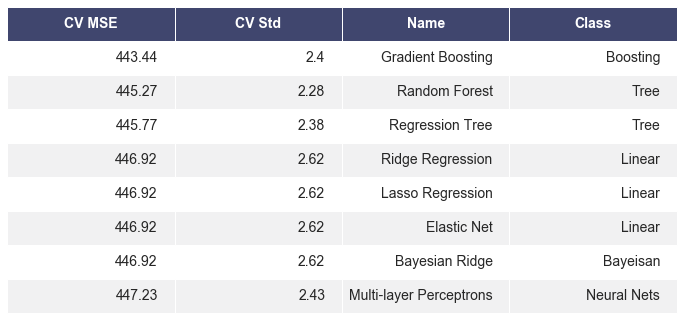

In [157]:
results = pd.DataFrame({'CV MSE':[-treekf.mean(), -rfrkf.mean(), -grakf.mean(),
                                -laskf.mean(), -ridkf.mean(), -baykf.mean(), -elakf.mean(), -mlpkf.mean()],
                      
                      'CV Std':[treekf.std(), rfrkf.std(), grakf.std(), 
                                laskf.std(), ridkf.std(), baykf.std(), elakf.std(), mlpkf.std()], 
                      
                     'Name':["Regression Tree","Random Forest","Gradient Boosting", 
                             "Lasso Regression", "Ridge Regression", "Bayesian Ridge", 
                            "Elastic Net",  "Multi-layer Perceptrons"],
                     
                     'Class':['Tree', 'Tree', 'Boosting', 'Linear', 'Linear', 
                              'Bayeisan', 'Linear', 'Neural Nets'],})
                     
results = results.sort_values(by=['CV MSE']).round(2)
render_mpl_table(results, header_columns=0, col_width=3.0)
plt.savefig('regres.png')

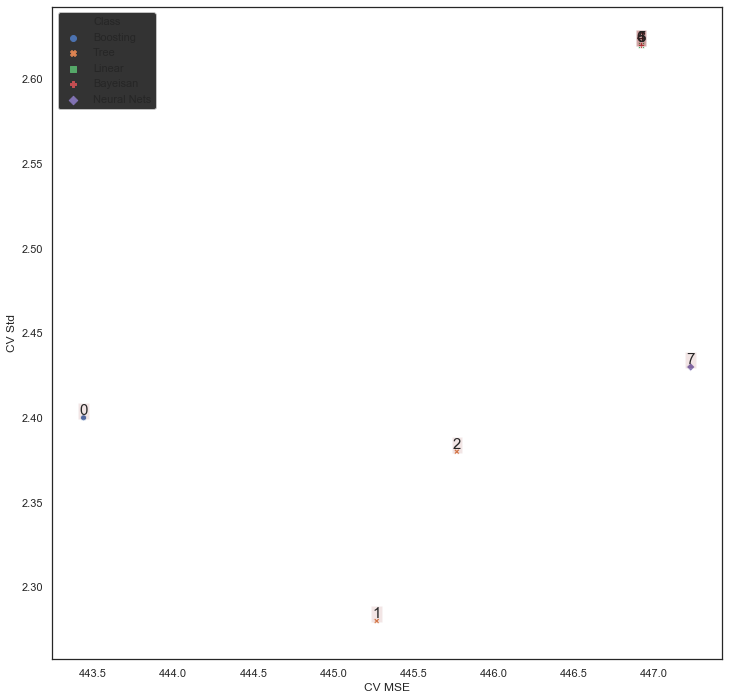

In [159]:
plt.figure(figsize = (12,12))

ax=sns.scatterplot(x = 'CV MSE', y = 'CV Std', hue = 'Class', style = 'Class',
                   data = results)
#plt.legend()
#ax.set_xlim(min(results['CV MSE']), max(results['CV MSE']))
#ax.set_ylim(min(results['CV Std']), max(results['CV Std']), 1000)
for line in range(0,results.shape[0]):
     ax.text(results['CV MSE'][line], results['CV Std'][line], 
             results.index[line], horizontalalignment = 'center', 
             verticalalignment = 'bottom',
             bbox = dict(facecolor = 'maroon', alpha = 0.1, pad = 1), fontsize = 15)
plt.savefig('Model Scatter.png')

In [158]:
results

,CV MSE,CV Std,Name,Class
2,443.44,2.40,Gradient Boosting,Boosting
1,445.27,2.28,Random Forest,Tree
0,445.77,2.38,Regression Tree,Tree
4,446.92,2.62,Ridge Regression,Linear
3,446.92,2.62,Lasso Regression,Linear
6,446.92,2.62,Elastic Net,Linear
5,446.92,2.62,Bayesian Ridge,Bayeisan
7,447.23,2.43,Multi-layer Perceptrons,Neural Nets


<Figure size 432x432 with 0 Axes>

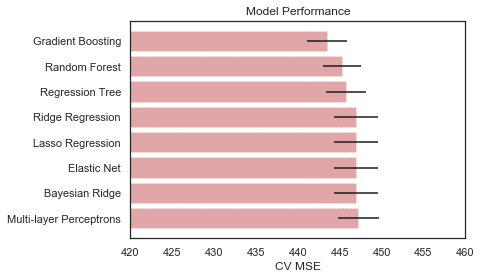

In [165]:
#plt.rcdefaults()
plt.figure(figsize = (6,6))

fig, ax = plt.subplots()

ax.barh(results['Name'], results['CV MSE'], xerr = results['CV Std'],
        align = 'center', color = 'r', alpha=0.5, ls = ":")
ax.set_xlim([420,460])
#ax.set_yticklabels(results['Name'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('CV MSE')
ax.set_title('Model Performance')
plt.savefig('Performance.png')

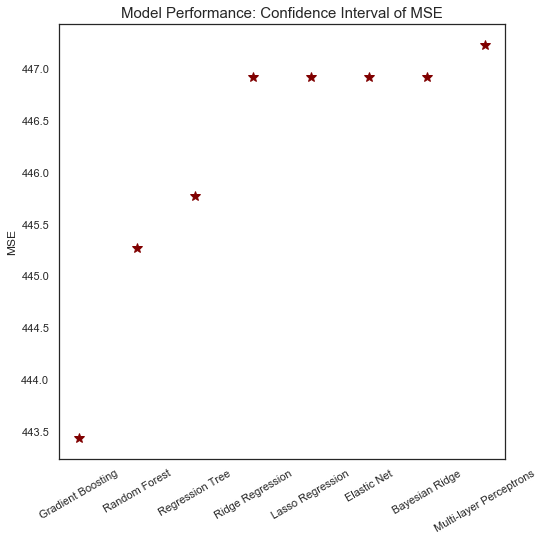

In [166]:
plt.figure(figsize = (8,8))

ind = results['Name']
mse = results['CV MSE']
err = results['CV Std']*1.96/np.sqrt(len(X))

plt.errorbar(ind, mse, err, linestyle = 'None', marker = '*',  mfc = 'maroon',
         mec='maroon', ms = 10, mew = 1, ls=':')

plt.xticks(rotation = 30)
plt.ylabel('MSE')
plt.title('Model Performance: Confidence Interval of MSE', fontsize = 15)
plt.savefig('Model Performance.png')

#### Performance on test set

In [168]:
mean_squared_error(gra.predict(X_test), y_test)

443.5375475814575

In [171]:
end = time.time()
print("Minutes to run",(end-start)/60)

Minutes to run 122.91877293189367


### Export data and model

In [173]:
X.head()

,cts_bus,star_bus,gender,weekend,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks,vegan,kid
0,13,4.000000,1,0,0,1,0,0,0,0,0,0,1,0,0
14,6,2.500878,0,0,1,1,0,0,0,0,0,0,0,0,0
17,6,2.500878,0,0,0,1,0,0,0,0,0,0,0,0,0
18,6,2.500878,0,0,0,1,0,0,0,0,0,0,0,0,0
23,349,3.000000,0,1,0,1,0,0,0,0,0,0,0,0,0


In [195]:
# save X data
X.to_csv("X.csv", encoding = 'utf-8', index = False)

In [196]:
# save business data
agg.to_csv("agg.csv", encoding='utf-8', index = False)

In [197]:
# save the model to disk
pickle.dump(gra, open('gradient_boosting_model.sav', 'wb'))

<IPython.core.display.Javascript object>